This script contains some improvement from train.ipynb by default:
* much few layers, heads, and embedding dimension to reduce the model size
* dataloader v2 which uses a custom tokenizer (again to reduce model size)
* no positional embeddings (to reduce model complexity)
* weight tying (to reduce model size)


We implemented a few things here first and not before:
* validation losses
* increased the model size to be just below 30M parameters
* reduced the amount of data trained with to keep the training (wall) time consistent
* made graph more informative

This script contains a couple improvements from train2.ipynb:
* gradient accumulation is enabled
* the dataloader chunks from the start of an example up to the max_length or the endoftext token

This contains some changes from train3.ipynb:
* an accuracy metric has been implemented
* one cycle learning rate schedule is being used
* weight tying is disabled

This contains some improvements from train4.ipynb: just that the attention module used uses pytorchs implementation for sdpa. This also uses a text generation function to display the capabilities of the trained model.

This contains some changes over train5.ipynb. We use data loading hooks for setting up the train/validation data loaders. We also use the setup hook for setting up the gpt model. We also call compile on the gpt model before training. We also have some code for investigating memory leaks.

The train6 files were used to determine the cause of the memory leak which seems to have been using multiple workers which causes copy-on-reads to occur. setting num_wokers=0 in the dataloader resolves this issue.
See issue: https://github.com/pytorch/pytorch/issues/13246#issuecomment-905703662
blogpost: https://ppwwyyxx.com/blog/2022/Demystify-RAM-Usage-in-Multiprocess-DataLoader/

The train7 files started using datasets processed by huggingface libraries. This file continues from there.

This file has many improvements over the train8.ipynb files. By default this script uses:
* packed sequences
* attention masks
* a deep model with many layers
* mixed precision training
* a small vocab of 4096 token ids

~~This file shows a huge improvement in accuracy and loss. Many possible explanations:~~
* ~~Rotational positional encoding was added~~
* ~~the dataset used was cleaned of weird symbols (accents, chinese characters, etc.)~~
* ~~smaller max_lr~~

Huge improvements were false negatives due to bad causal mask construction (data leakage)

Further improvements:
* apply positions from dataset to RoPE
* turn off default positional encodings (or use positions from dataset)

In [1]:
from tokenizers import Tokenizer

tokenizer = Tokenizer.from_file("./TinyStories_tokenizer_small_cleaned.json")
vocab_size = tokenizer.get_vocab_size()

In [2]:
GPT_CONFIG_30M = {
    "vocab_size": vocab_size,
    "context_length": 512,
    "emb_dim": 512,
    "n_heads": 4,
    "n_layers": 4,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": True,
    "no_pos_emb": True
}

In [3]:
GPT_CONFIG_30M_small_emb = {
    "vocab_size": vocab_size,
    "context_length": 512,
    "emb_dim": 256,
    "n_heads": 16,
    "n_layers": 18,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": False
}

In [4]:
GPT_CONFIG_60M = {
    "vocab_size": vocab_size,
    "context_length": 512,
    "emb_dim": 512,
    "n_heads": 8,
    "n_layers": 8,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": False # conflicts with sequence packing
}

In [5]:
GPT_CONFIG_120M_DEEP = {
    "vocab_size": vocab_size,
    "context_length": 512, # this must be multiple of 64 for the flash attention implementation
    "emb_dim": 512, # this must be multiple of 16 * n_heads for the flash attention implementation
    "n_heads": 32,
    "n_layers": 36,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": True # conflicts with sequence packing
}

In [6]:
GPT_CONFIG_120M_SHALLOW = {
    "vocab_size": vocab_size,
    "context_length": 512,
    "emb_dim": 768,
    "n_heads": 64,
    "n_layers": 10,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": False # conflicts with sequence packing
}

In [7]:
import socket
hostname = socket.gethostname().lower()
if "laptop" in hostname:
    GPT_CONFIG = GPT_CONFIG_30M
else:
    GPT_CONFIG = GPT_CONFIG_120M_DEEP

In [8]:
import torch.nn as nn
import torch

torch.set_float32_matmul_precision('medium')

In [9]:
trainer_config = {
    "batch_size": 32 if "laptop" in hostname else 32,
    "epochs": 3,
    "num_workers": 23,
    "max_lr": 1e-3 / 2,
    "compile": "laptop" not in hostname
}
trainer_config["grad_batches"] = 256 // trainer_config["batch_size"]

In [10]:
from components.gptmodel import GPTModel_RoPE
from torch.optim.lr_scheduler import OneCycleLR
import lightning as L
from datasets import load_from_disk
from torch.utils.data import DataLoader


class LitGPTModel(L.LightningModule):
    def __init__(self, trainer_config, gpt_config):
        super().__init__()
        self.save_hyperparameters()
        self.gpt_config = gpt_config
        self.trainer_config = trainer_config

        self.train_accuracy = []
        self.val_accuracy = []
        self.train_losses = []
        self.val_losses = []
        self.val_steps = []
        self.learning_rates = []
        self.batch_step = 0

    def _accuracy(self, output, expected):
        total_matching = (torch.argmax(output, dim=-1) == expected).sum().item()
        total_numel = expected.numel()
        return total_matching / total_numel

    def training_step(self, batch, batch_idx):
        self.batch_step += 1

        x, y = batch["packed_inputs"][:, :-1], batch["packed_inputs"][:, 1:]
        attn_mask = batch["attention_mask"][:, :-1, :-1]
        positions = batch["padded_positions"][:, :-1]
        logits = self.model([x, attn_mask, positions])

        accuracy = self._accuracy(logits, y)
        self.log("accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.train_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.train_losses.append(loss.item())

        current_lr = self.optimizers().param_groups[0]["lr"]
        self.learning_rates.append(current_lr)

        return loss

    def validation_step(self, batch, batch_idx):
        self.val_steps.append(self.batch_step)
        x, y = batch["packed_inputs"][:, :-1], batch["packed_inputs"][:, 1:]
        attn_mask = batch["attention_mask"][:, :-1, :-1]
        positions = batch["padded_positions"][:, :-1]
        logits = self.model([x, attn_mask, positions])

        accuracy = self._accuracy(logits, y)
        self.log("val_accuracy", accuracy, prog_bar=True, on_step=True, on_epoch=True)
        self.val_accuracy.append(accuracy)

        loss = self.loss(logits, y)
        self.log("val_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.val_losses.append(loss.item())
        
        return loss

    def loss(self, output, expected):
        loss = nn.functional.cross_entropy(
            output.flatten(0, 1), expected.flatten()
        )
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.trainer_config["max_lr"], weight_decay=0.1
        )

        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.trainer_config["max_lr"],
            total_steps=self.trainer.estimated_stepping_batches,
        )
        lr_scheduler_config = {
            "scheduler": scheduler,
            "interval": "step",
            "monitor": "loss"
        }

        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler_config
        }

    def setup(self, stage):
        self.packed_dataset = load_from_disk("packed_dataset_with_mask_smallVocab_cleaned")
        self.packed_dataset.set_format('torch')

    def configure_model(self):
        self.model = GPTModel_RoPE(self.gpt_config)
        if self.trainer_config["compile"]:
            self.model = torch.compile(self.model, fullgraph=True)


    def train_dataloader(self):
        return DataLoader(
            self.packed_dataset["train"],
            batch_size=self.trainer_config["batch_size"],
            shuffle=True,
            num_workers=self.trainer_config["num_workers"],
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=2,
        )

    def val_dataloader(self):
        return DataLoader(
            self.packed_dataset["validation"],
            batch_size=self.trainer_config["batch_size"],
            shuffle=False,
            num_workers=self.trainer_config["num_workers"],
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=2,
        )


/home/gebrial/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
litmodel = LitGPTModel(
    trainer_config,
    GPT_CONFIG
)

In [12]:
# %%time
from lightning.pytorch.callbacks import ModelCheckpoint

trainer = L.Trainer(
    max_epochs=trainer_config["epochs"],
    logger=False,
    enable_progress_bar=True,
    accumulate_grad_batches=trainer_config["grad_batches"],
    gradient_clip_val=1.0,
    enable_checkpointing=True,
    callbacks=[
        ModelCheckpoint(
            save_top_k=-1,
            every_n_epochs=1,
            dirpath="./checkpoints/120M_DEEP_smallVocabCleaned_RoPE2/"
        )
    ],
    precision="bf16-mixed" # or "transformer-engine" for 8-bit mixed
)
trainer.fit(model=litmodel)

INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loading `train_dataloader` to estimate number of stepping batches.
INFO:lightning.pytorch.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
INFO: 
  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | OptimizedModule | 117 M  | train
----------------

Epoch 2: 100%|██████████| 30160/30160 [2:12:53<00:00,  3.78it/s, accuracy_step=0.626, loss_step=1.370, val_accuracy_step=0.683, val_loss_step=1.160, val_accuracy_epoch=0.695, val_loss_epoch=1.100, accuracy_epoch=0.687, loss_epoch=1.140]  

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 30160/30160 [2:12:55<00:00,  3.78it/s, accuracy_step=0.626, loss_step=1.370, val_accuracy_step=0.683, val_loss_step=1.160, val_accuracy_epoch=0.695, val_loss_epoch=1.100, accuracy_epoch=0.687, loss_epoch=1.140]


In [13]:
# trainer.save_checkpoint(
#     "./checkpoints/120M_DEEP_smallVocabCleaned_RoPE.ckpt",
# )

In [14]:
# loaded_model = LitGPTModel.load_from_checkpoint(
#   checkpoint_path="./checkpoints/120M_DEEP_smallVocabCleaned_RoPE.ckpt",
# )
# # make sure NOT to compile so that we can load from checkpoint

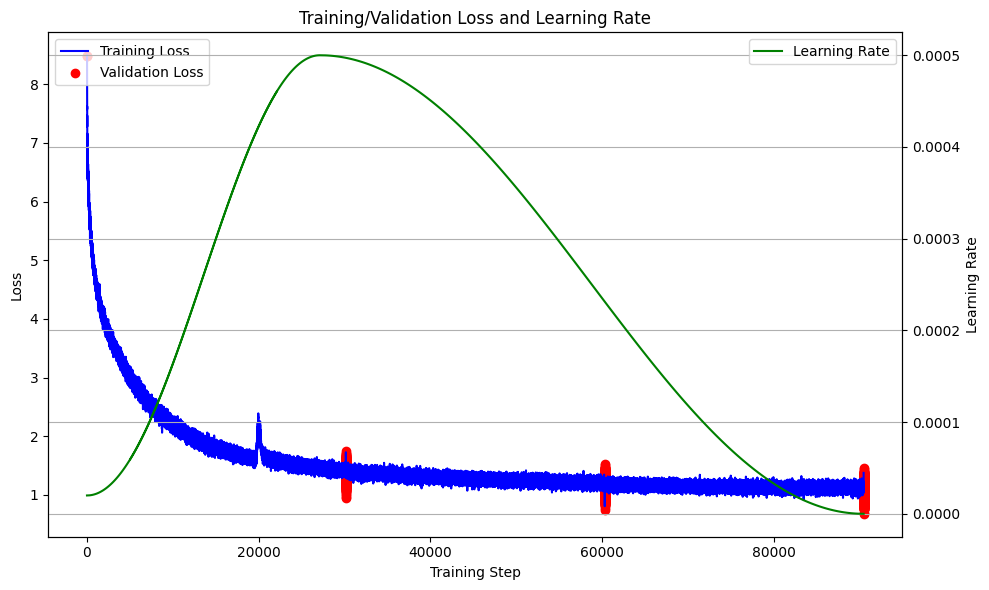

In [15]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(litmodel.train_losses, label="Training Loss", color="blue")
ax1.scatter(litmodel.val_steps, litmodel.val_losses, label="Validation Loss", color="red")
ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(litmodel.learning_rates, label="Learning Rate", color="green")
ax2.set_ylabel("Learning Rate")
ax2.legend(loc="upper right")

plt.title("Training/Validation Loss and Learning Rate")
plt.tight_layout()
plt.grid(True)
plt.show()

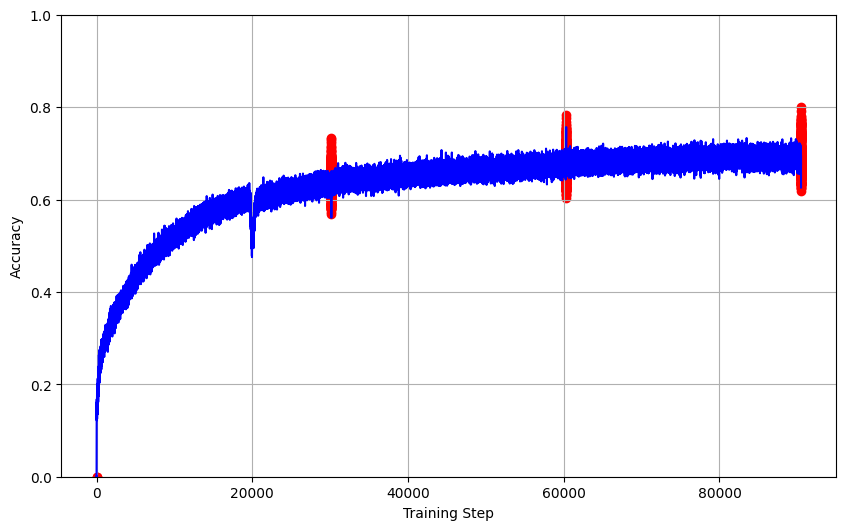

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(litmodel.train_accuracy, color="blue")
plt.scatter(litmodel.val_steps, litmodel.val_accuracy, color="red")
plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.grid(True)
plt.ylim(0, 1)
plt.show()

In [17]:
from tokenizers import Tokenizer

In [18]:
tokenizer = Tokenizer.from_file("./TinyStories_tokenizer_small_cleaned.json")

In [19]:
from tokenizers import decoders
tokenizer.decoder = decoders.WordPiece()

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
litmodel.model.to(device)

OptimizedModule(
  (_orig_mod): GPTModel_RoPE(
    (tok_emb): Embedding(4096, 512)
    (pos_emb): Embedding(512, 512)
    (drop_emb): Dropout(p=0.1, inplace=False)
    (trf_blocks): Sequential(
      (0): TransformerBlock_RoPE(
        (att): MultiHeadAttention_RoPE(
          (W_query): Linear(in_features=512, out_features=512, bias=False)
          (W_key): Linear(in_features=512, out_features=512, bias=False)
          (W_value): Linear(in_features=512, out_features=512, bias=False)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
          (rope): RotaryPositionalEmbeddings()
        )
        (ff): FeedForward(
          (layers): Sequential(
            (0): Linear(in_features=512, out_features=2048, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=2048, out_features=512, bias=True)
          )
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e

In [21]:
sum([p.numel() for p in litmodel.model.parameters() if p.requires_grad])

117888000

In [22]:
from components.generatetext import generate_text_with_attn_positions


litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text_with_attn_positions(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)


text:  tom and jane are friends. one day, jane goes to tom ' s house. tom has a big pot of soup. he wants to share it with jane. " jane, do you want some soup?" tom asks. " yes, please. it looks yummy," jane says. tom p ours some soup into two bowl s. he gives one bowl to jane. jane takes a spoon ful of soup, but then she makes a face. the soup is bitter and not sweet like tom had. " yuck! it tast s bitter," jane said with tears coming up in jane ' s mouth s from tom a. " it is bitter because i added something sour," jane ad v ises her ton vis. " it ' s too bitter for you." " i ' m sorry, jane, i ' ve added a bitter ingredient. here," tom gives jane a new pot of sweet, bitter stuff to try again," tom says, giving jane a new spoon ful. " try it now. you will feel better soon." jane takes a bite and it tast s much sweet er than tom ' s old bowl of soup! jane smiled and thanked tom. they finished eating the sweet soup, happy and full of sweet taste. they were glad they had each other as f

In [23]:
import csv
import time

with open('evaluation_prompts.csv', mode='r') as file:
    csv_reader = csv.DictReader(file)
    data = [row for row in csv_reader]  # Each row is a dictionary

data_len = len(data)
current_index = 0
# measure time
start_time = time.time()
# Modify data (e.g., change 'age' column to integers)
for row in data:
    current_index += 1
    starting_text = row['prompt']
    output_text = generate_text_with_attn_positions(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1, output_only=True)
    row['completion'] = output_text
    if current_index % 10 == 0:
        # print prompt
        print(f"Prompt {current_index}: {starting_text}")
        # print output
        print(f"Row {current_index}: {output_text}")
        current_time = time.time()
        elapsed_time = current_time - start_time
        time_left = (data_len - current_index) * (elapsed_time / current_index)
        print(f"Processed {current_index}/{data_len} rows. Estimated time left: {time_left:.2f} seconds.")


Prompt 10: One day a girl walked into the living room and noticed something very strange. There was a huge cabinet standing in the corner. It looked very old and heavy. She walked over and tried to open it, when suddenly
Row 10: the door closed behind them! she started to pan ic, but she was determined to open the cabinet. after some time, she managed to open it. she looked in, surprised by all of its content ment s. there were all of her favourite toys, and she couldn a ke with her tiny fingers. but then, she saw something even bigger. there, in one side, were two little eyes! she was so scared that her heart was ra iling. but she knew she was brave, so with all her courage, slowly opened the door. she saw two big, friendly eyes looking right at her. she smiled and said, a hi! a the two little friends had become friends. they spent the whole day exploring the huge bookcase and having lots of laughs! the little girl had found her new com mit ment and made a new best of friendship! she 

In [24]:
with open('evaluation_outputs_smallVocabCleaned_RoPE.csv', mode='w', newline='') as file:
    fieldnames = data[0].keys()  # Get column names
    csv_writer = csv.DictWriter(file, fieldnames=fieldnames)
    csv_writer.writeheader()
    csv_writer.writerows(data)

In [25]:
trainer.validate()

/home/gebrial/miniforge3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO: Restoring states from the checkpoint path at /home/gebrial/projects/llm-from-scratch/src/checkpoints/120M_DEEP_smallVocabCleaned_RoPE2/epoch=2-step=11310.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /home/gebrial/projects/llm-from-scratch/src/checkpoints/120M_DEEP_smallVocabCleaned_RoPE2/epoch=2-step=11310.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /home/gebrial/projects/llm-from-scratch/src/che

Validation DataLoader 0: 100%|██████████| 304/304 [01:19<00:00,  3.83it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    val_accuracy_epoch     │    0.6951237916946411     │
│      val_loss_epoch       │     1.10127592086792      │
└───────────────────────────┴───────────────────────────┘

[{'val_accuracy_epoch': 0.6951237916946411,
  'val_loss_epoch': 1.10127592086792}]